# Table of Contents

* [Project Description](#pd)
* [Load Packages](#lp)
* [Read Data](#rd)
* [Data Visualization and Description](#dvd)
* [Decomposition](#d)
* [Train Test Spilt](#tts)
* [Modeling](#m)
    * [ARIMA](#arima)
        * [Box Cox Transformation](#arima_boxcox)
        * [Order Selection by ACF and PACF Plots](#arima_order_plot)
        * [Order Selection by Automated Algorithm](#arima_order_algo)
    * [ETS](#ets)
* [Residuals Diagnostics](#resid_diag)
* [Model Evaluation and Forecasting](#eval)
* [References](#ref)

# Project Description <a id="pd"></a>

Durable consumer goods, such as cars and computers, are less prone to fluctuations in demand than non-durable goods like food. Therefore, the consumption of durable goods can be a good indicator of people's spending power. This is why the Industrial Production Index of durable consumer goods, which is often driven by demand, can provide valuable insights into the demand for these goods and people's ability to spend.
  
This project analyzes the historical time series of the Industrial Production Index of Durable Consumer Goods and builds a forecasting model on it.
  
**Data source**:  
Board of Governors of the Federal Reserve System (US), Industrial Production: Durable Consumer Goods [IPB51100N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPB51100N, December 2, 2023.

# Load Packages <a id="lp"></a>

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.seasonal import STL
from sktime.transformations.series.boxcox import BoxCoxTransformer
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_absolute_error
import warnings
from pmdarima.arima import auto_arima

# Read Data <a id="rd"></a>

In [2]:
df = pd.read_csv('IPB51100N.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526 entries, 0 to 525
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DATE       526 non-null    object 
 1   IPB51100N  526 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.3+ KB


In [3]:
series = df['IPB51100N']
series.index = pd.date_range(start='1980-01-01', end='2023-10-01', freq='MS')
series.name = 'Durable Consumer Goods Production Index'
series

1980-01-01     43.6669
1980-02-01     45.3866
1980-03-01     45.8519
1980-04-01     43.3564
1980-05-01     40.6400
                ...   
2023-06-01    107.7999
2023-07-01     98.7340
2023-08-01    108.1580
2023-09-01    106.2973
2023-10-01    103.4596
Freq: MS, Name: Durable Consumer Goods Production Index, Length: 526, dtype: float64

# Data Visualization and Description <a id="dvd"></a>

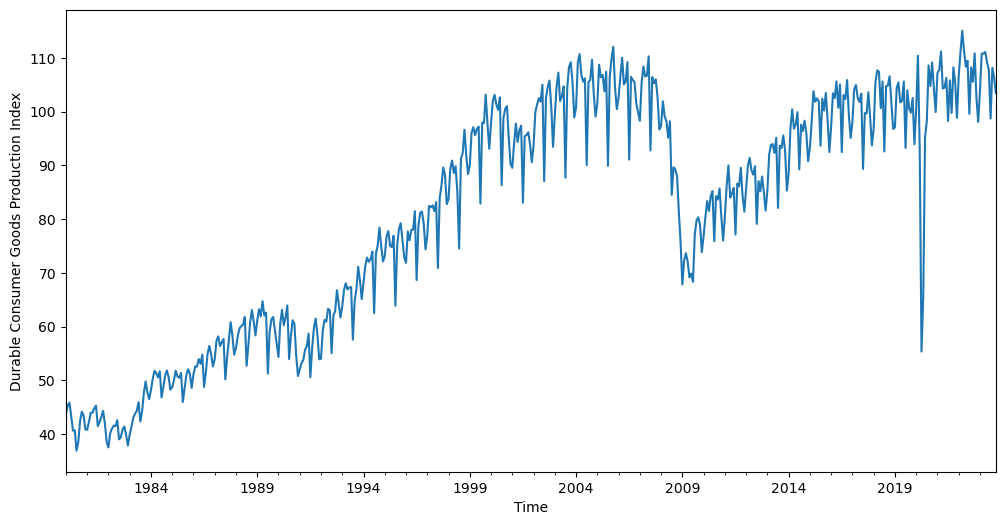

In [4]:
plt.figure(figsize=(12, 6))
series.plot()
plt.xlabel('Time')
plt.ylabel(series.name)
plt.show()

**Interpretation**  
- This series shows a general upward trend and clear seasonality.  
- The 2008 financial crisis had a significant impact on the production of durable consumer goods. Due to the crisis, people's spending ability was profoundly affected, resulting in a substantial decrease in demand for durable consumer goods. This, in turn, caused a drop in the production index. It takes around a decade for the production index to recover to the same level as before the financial crisis.
- The COVID-19 pandemic also hurt people's ability to spend, which decreased the demand and production of durable consumer goods. However, the effect is much less profound than the 2008 financial crisis as it only takes about 1 year for the index to recover to the pre-pandemic level.

# Decomposition <a id="d"></a>

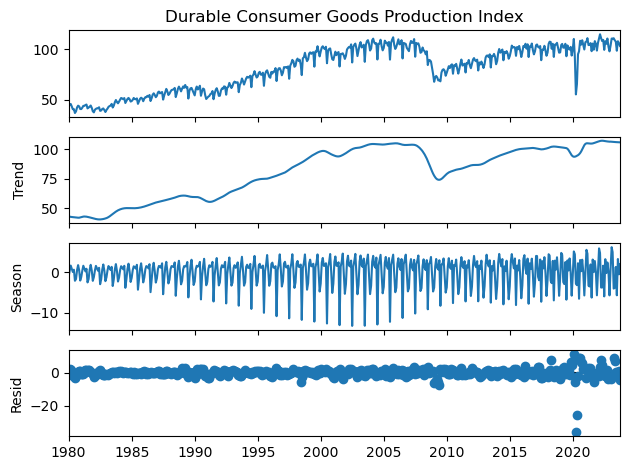

In [5]:
stl = STL(series, seasonal=13).fit()
stl.plot()
plt.show()

# Train Test Spilt <a id="tts"></a>

In [6]:
prediction_length = 12
train = series.iloc[:series.size - prediction_length].copy()
test = series.iloc[-prediction_length:].copy()
print('Training Set')
print(train)
print('\nTesting Set')
print(test)

Training Set
1980-01-01     43.6669
1980-02-01     45.3866
1980-03-01     45.8519
1980-04-01     43.3564
1980-05-01     40.6400
                ...   
2022-06-01    109.4872
2022-07-01     99.6096
2022-08-01    108.2316
2022-09-01    105.5706
2022-10-01    110.8433
Freq: MS, Name: Durable Consumer Goods Production Index, Length: 514, dtype: float64

Testing Set
2022-11-01    102.7104
2022-12-01     98.0826
2023-01-01    103.8042
2023-02-01    110.8062
2023-03-01    110.8154
2023-04-01    111.1144
2023-05-01    109.1915
2023-06-01    107.7999
2023-07-01     98.7340
2023-08-01    108.1580
2023-09-01    106.2973
2023-10-01    103.4596
Freq: MS, Name: Durable Consumer Goods Production Index, dtype: float64


# Modeling <a id="m"></a>

In [7]:
arima_models = {}
ets_models = {}

## ARIMA Model <a id="arima"></a>

### Box-Cox Transformtaion <a id="arima_boxcox"></a>

Since seasonal component varies largely with time, we use Box-Cox Transformation to stablize variance.

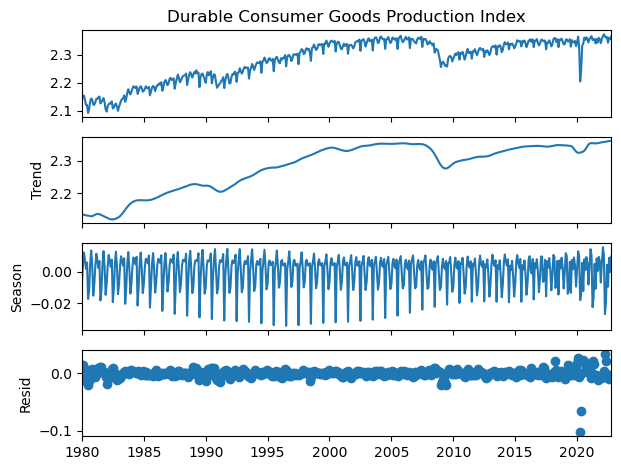

In [8]:
transformer = BoxCoxTransformer(method='guerrero', sp=12)
transformed_train = transformer.fit_transform(train)
stl = STL(transformed_train, seasonal=13).fit()
stl.plot()
plt.show()

### Order Selection by ACF and PACF Plots <a id="arima_order_plot"></a>

In [9]:
def tsdisplay(ts, title=None):
    fig = plt.figure(figsize=(12, 10))
    ax1 = fig.add_subplot(311)
    ax1.plot(ts)
    ax1.set_title(title)
    ax2 = fig.add_subplot(312)
    sm.graphics.tsa.plot_acf(ts, lags=40, ax=ax2)
    ax3 = fig.add_subplot(313)
    sm.graphics.tsa.plot_pacf(ts, lags=40, ax=ax3)
    plt.show()
    return None

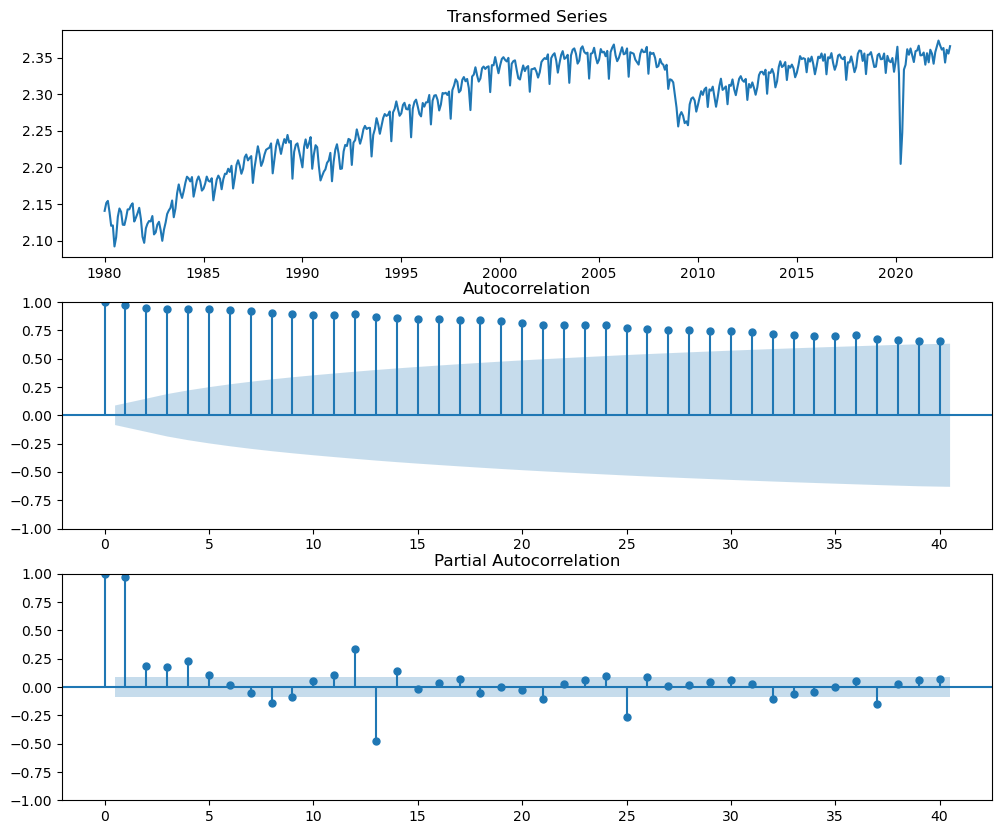

In [10]:
tsdisplay(ts=transformed_train, title='Transformed Series')

There is an increasing trend, let's do one nonseasonal differencing

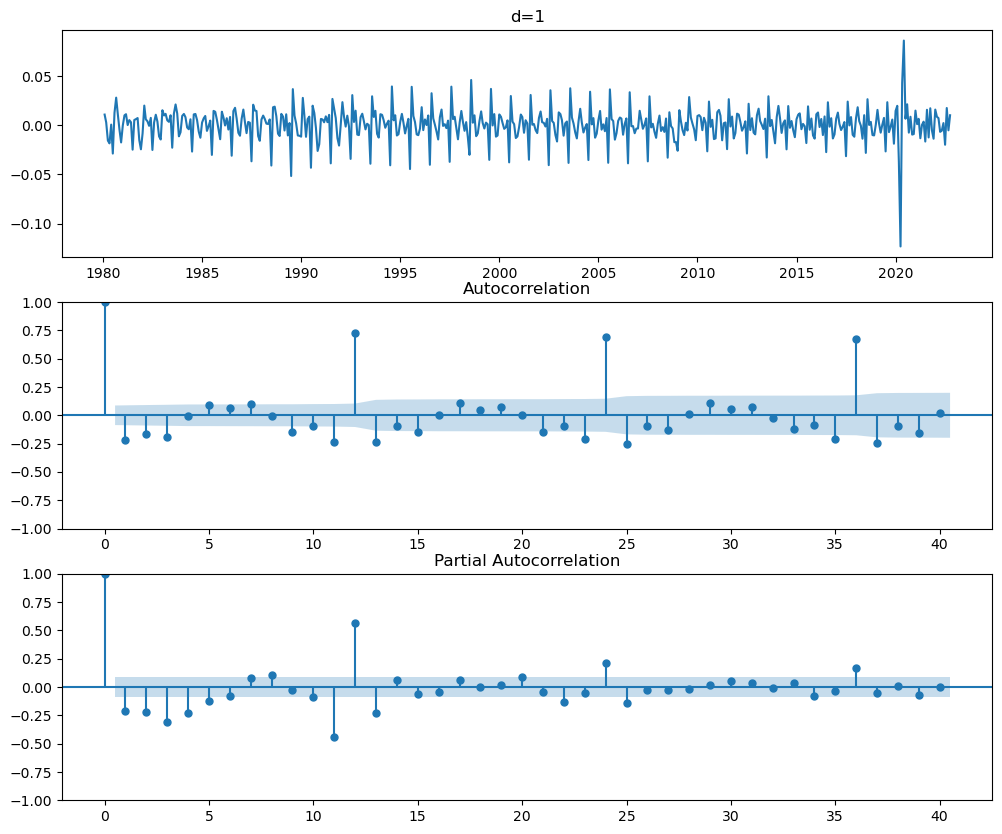

In [11]:
tsdisplay(ts=transformed_train.diff(1).dropna(), title='d=1')

There is seasonality remaining, let's do a seasonal differencing.

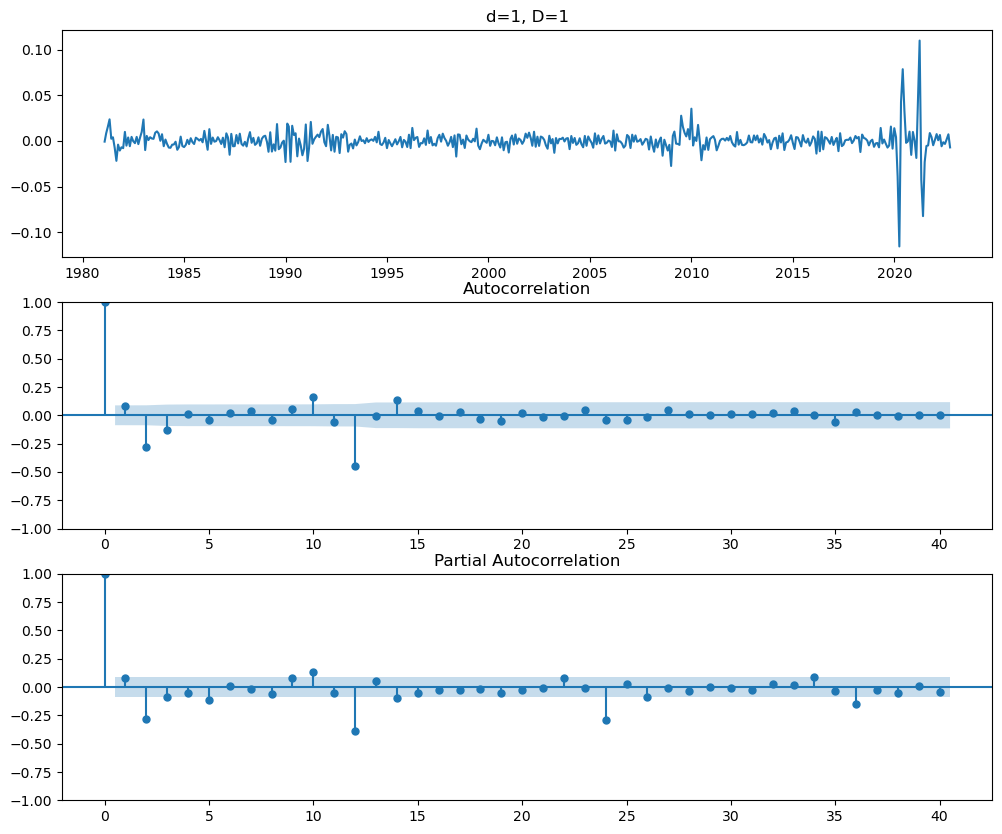

In [12]:
tsdisplay(ts=transformed_train.diff(1).dropna().diff(12).dropna(), title='d=1, D=1')

The series now appears to be stationary, let's verify using ADF test.

In [13]:
ts, p, *_ = adfuller(transformed_train.diff(1).dropna().diff(12).dropna())
if p < 0.05:
    print(f'p-value = {p} < 0.05, we reject null and conclude the series is now stationary.')
else:
    print(f'p-value = {p} >= 0.05, not stationary yet')

p-value = 7.963442071787125e-14 < 0.05, we reject null and conclude the series is now stationary.


We see one seasonal lag in ACF and three seasonal lag in PACF. So, it looks like a seasonal MA(1). We set $P = 0$ and $Q = 1$.  
There is no obvious pattern for nonseasonal terms, let's try some values of $p$ and $q$ and compare their AICc.

In [14]:
warnings.filterwarnings('ignore')

In [15]:
list_p = list(range(4))
list_q = list(range(4))
AICcs = np.zeros((len(list_p), len(list_q)))

for p in list_p:
    for q in list_q:
        res = ARIMA(transformed_train, order=(p,1,q), seasonal_order=(0,1,1,12)).fit()
        AICcs[p, q] = res.aicc

min_idx = np.argmin(AICcs)
min_idx = (min_idx//len(list_q), min_idx%len(list_q))
print(f'p = {min_idx[0]}, q = {min_idx[1]}, minimum AICc = {AICcs[min_idx]}')

p = 0, q = 3, minimum AICc = -3275.764648213271


According to AICc, the best model is $\text{ARIMA } (0,1,3)\times(0, 1, 1)_{12}$

In [16]:
arima_plot = ARIMA(transformed_train, order=(0,1,3), seasonal_order=(0,1,1,12)).fit()
print(f'Model AICc = {arima_plot.aicc}')
arima_plot.summary()

Model AICc = -3275.764648213271


<class 'statsmodels.iolib.summary.Summary'>
"""
                                          SARIMAX Results                                          
===================================================================================================
Dep. Variable:     Durable Consumer Goods Production Index   No. Observations:                  514
Model:                      ARIMA(0, 1, 3)x(0, 1, [1], 12)   Log Likelihood                1642.943
Date:                                     Wed, 24 Jan 2024   AIC                          -3275.886
Time:                                             22:47:33   BIC                          -3254.803
Sample:                                         01-01-1980   HQIC                         -3267.614
                                              - 10-01-2022                                         
Covariance Type:                                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0348      0.016      2.236      0.025       0.004       0.065
ma.L2         -0.2687      0.017    -16.162      0.000      -0.301      -0.236
ma.L3         -0.1715      0.025     -6.955      0.000      -0.220      -0.123
ma.S.L12      -0.8154      0.029    -27.683      0.000      -0.873      -0.758
sigma2      8.071e-05    1.3e-06     61.862      0.000    7.82e-05    8.33e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             63348.00
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               3.07   Skew:                            -3.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        57.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
arima_models['arima_plot'] = arima_plot

### Order Selection by Automated Algorithm <a id="arima_order_algo"></a>

In [18]:
auto_arima(transformed_train, 
           start_p=0, d=None, start_q=0, max_p=5, max_d=2, max_q=5, 
           start_P=0, D=None, start_Q=0, max_P=5, max_D=1, max_Q=5, 
           m=12, information_criterion='aicc')

ARIMA(order=(2, 1, 1), scoring_args={}, seasonal_order=(3, 0, 2, 12),
      suppress_warnings=True, with_intercept=False)

In [19]:
arima_algo = ARIMA(transformed_train, order=(2,1,1), seasonal_order=(3,0,2,12)).fit()
print(f'Model AICc = {arima_algo.aicc}')
arima_algo.summary()

Model AICc = -3342.4354066762003


<class 'statsmodels.iolib.summary.Summary'>
"""
                                          SARIMAX Results                                          
===================================================================================================
Dep. Variable:     Durable Consumer Goods Production Index   No. Observations:                  514
Model:                   ARIMA(2, 1, 1)x(3, 0, [1, 2], 12)   Log Likelihood                1680.397
Date:                                     Wed, 24 Jan 2024   AIC                          -3342.793
Time:                                             22:50:53   BIC                          -3304.631
Sample:                                         01-01-1980   HQIC                         -3327.835
                                              - 10-01-2022                                         
Covariance Type:                                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5826      0.076      7.638      0.000       0.433       0.732
ar.L2         -0.2765      0.017    -16.153      0.000      -0.310      -0.243
ma.L1         -0.5461      0.082     -6.669      0.000      -0.707      -0.386
ar.S.L12       0.4172      0.542      0.770      0.441      -0.645       1.479
ar.S.L24       0.4729      0.603      0.784      0.433      -0.709       1.655
ar.S.L36       0.0871      0.120      0.727      0.467      -0.148       0.322
ma.S.L12      -0.1707      0.544     -0.314      0.754      -1.237       0.895
ma.S.L24      -0.4323      0.459     -0.941      0.347      -1.333       0.468
sigma2      8.058e-05   1.84e-06     43.810      0.000     7.7e-05    8.42e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):             63840.07
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               2.99   Skew:                            -3.90
Prob(H) (two-sided):                  0.00   Kurtosis:                        57.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Based on AICc, we see the order selected by `auto_arima` works beter. Let's save both models for further evaluation.

In [20]:
arima_models['arima_algo'] = arima_algo

## ETS <a id="ets"></a>

Our series shows strong trend and seasonality with increasing magnitude. Also, the trend is diminishing near the end of the series.  
So $\text{ETS}(A,A_{d},M)$ or $\text{ETS}(M,A_{d},M)$ may be more appropriate.  
For completeness, we try all of the following ETS methods and compare results later.
- $\text{ETS}(A,A,A)$
- $\text{ETS}(A,A,M)$
- $\text{ETS}(A,A_{d},A)$
- $\text{ETS}(A,A_{d},M)$
- $\text{ETS}(M,A,A)$
- $\text{ETS}(M,A,M)$
- $\text{ETS}(M,A_{d},A)$
- $\text{ETS}(M,A_{d},M)$

In [ ]:
ets_models['ETS_A_A_A'] = ETSModel(train, error='add', trend='add', damped_trend=False, seasonal='add').fit()
ets_models['ETS_A_A_M'] = ETSModel(train, error='add', trend='add', damped_trend=False, seasonal='mul').fit()
ets_models['ETS_A_Ad_A'] = ETSModel(train, error='add', trend='add', damped_trend=True, seasonal='add').fit()
ets_models['ETS_A_Ad_M'] = ETSModel(train, error='add', trend='add', damped_trend=True, seasonal='mul').fit()
ets_models['ETS_M_A_A'] = ETSModel(train, error='mul', trend='add', damped_trend=False, seasonal='add').fit()
ets_models['ETS_M_A_M'] = ETSModel(train, error='mul', trend='add', damped_trend=False, seasonal='mul').fit()
ets_models['ETS_M_Ad_A'] = ETSModel(train, error='mul', trend='add', damped_trend=True, seasonal='add').fit()
ets_models['ETS_M_Ad_M'] = ETSModel(train, error='mul', trend='add', damped_trend=True, seasonal='mul').fit()

# Residuals Diagnostics <a id="resid_diag"></a>

In [22]:
def residual_diagnostics(model, alpha = 0.05):
    return [model.test_serial_correlation(method='ljungbox', lags=[20]).flatten()[1] >= alpha, 
            model.resid.mean(),
            model.test_heteroskedasticity('breakvar').flatten()[1] >= alpha, 
            model.test_normality('jarquebera').flatten()[1] >= alpha]

In [23]:
arima_diag_summary = pd.DataFrame({name:residual_diagnostics(model) for name, model in arima_models.items()}).T
ets_diag_summary = pd.DataFrame({name:residual_diagnostics(model) for name, model in ets_models.items()}).T
resid_diag_summary = pd.concat([arima_diag_summary, ets_diag_summary])
resid_diag_summary.columns = ['No serial correlation', 'Residual mean', 'No heteroskedasticity', 'Normality']
resid_diag_summary

,No serial correlation,Residual mean,No heteroskedasticity,Normality
arima_plot,True,0.002183,False,False
arima_algo,True,0.004276,False,False
ETS_A_A_A,False,0.050573,False,False
ETS_A_A_M,False,-0.001762,False,False
ETS_A_Ad_A,False,0.147653,False,False
ETS_A_Ad_M,False,0.126569,False,False
ETS_M_A_A,False,-0.000408,False,False
ETS_M_A_M,False,-0.000381,False,False
ETS_M_Ad_A,False,0.002981,False,False
ETS_M_Ad_M,False,0.00257,False,False


There is serial correlation left in the residuals of ETS models, which means the ETS models are not using all available information.  
We will still take the ETS models into account and evaluate their forecasting accuracy. As [Hyndman & Athanasopoulos, 2021](#ref) said, "Checking these properties is important in order to see whether a method is using all of the available information, but it is not a good way to select a forecasting method".

# Model Evaluation and Forecasting <a id="eval"></a>

According to the paper by [Hewamalage et al., 2022](#ref), we will choose mean absolute error (MAE) as the evaluation metric.

In [24]:
arima_summary = pd.Series({name:mean_absolute_error(test, transformer.inverse_transform(model.forecast(prediction_length))) for name, model in arima_models.items()})
ets_summary = pd.Series({name:mean_absolute_error(test, model.forecast(prediction_length)) for name, model in ets_models.items()})
forecast_summary = pd.concat([arima_summary, ets_summary]).to_frame('MAE')
forecast_summary.sort_values(by='MAE')

,MAE
ETS_A_Ad_M,2.400770
ETS_A_A_M,2.503808
ETS_A_Ad_A,2.913373
ETS_M_Ad_M,3.022503
ETS_M_Ad_A,3.209143
ETS_M_A_M,3.361936
ETS_A_A_A,3.569457
ETS_M_A_A,3.964787
arima_plot,4.384495
arima_algo,5.305239


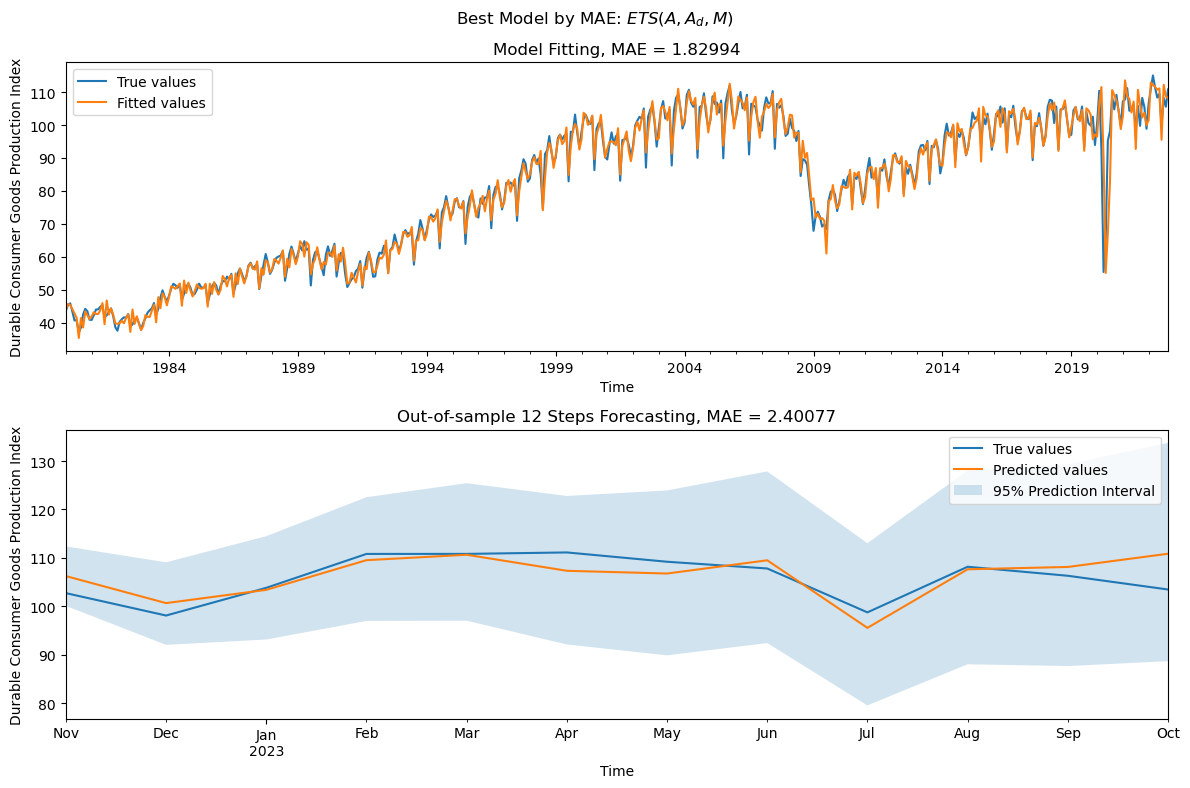

In [25]:
best_model = ets_models['ETS_A_Ad_M']
alpha = 0.05
forecast = best_model.get_prediction(start=test.index[0], end=test.index[-1]).summary_frame(alpha=alpha)
mean = forecast['mean']
lower_bound = forecast['pi_lower']
upper_bound = forecast['pi_upper']

fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(211)
train.plot(label='True values', ax=ax1)
best_model.fittedvalues.plot(label='Fitted values', ax=ax1)
ax1.set_title(f'Model Fitting, MAE = {round(best_model.mae, 5)}')
ax1.set_xlabel('Time')
ax1.set_ylabel(train.name)
ax1.legend()

ax2 = fig.add_subplot(212)
test.plot(label='True values', ax=ax2)
mean.plot(label='Predicted values', ax=ax2)
ax2.fill_between(test.index, lower_bound, upper_bound, alpha=0.2, label=f'{round((1-alpha)*100)}% Prediction Interval')
ax2.set_title(f'Out-of-sample {test.size} Steps Forecasting, MAE = {round(mean_absolute_error(test, mean), 5)}')
ax2.set_xlabel('Time')
ax2.set_ylabel(test.name)
ax2.legend()

plt.suptitle(r'Best Model by MAE: $ETS(A, A_d, M)$')
plt.tight_layout()
plt.show()

# References <a id='ref'></a>

- Board of Governors of the Federal Reserve System (US), Industrial Production: Durable Consumer Goods [IPB51100N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPB51100N, December 2, 2023.
- Hansika Hewamalage, Klaus Ackermann, & Christoph Bergmeir. (2022). Forecast Evaluation for Data Scientists: Common Pitfalls and Best Practices.
- Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia. OTexts.com/fpp3. Accessed on December 2, 2023.